In [1]:
# Merger rate for IMRIPY system when they throw away all of the dark matter before merging.

import numpy as np
import matplotlib.pyplot as plt
import imripy
from imripy import merger_system as ms
from scipy.interpolate import interp1d
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit
from numpy import diff
import mass_function
from sympy import *
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})
   


π = np.pi
Ω_cdm = 0.85
G = 4.4959e-15            #in units of M☉^-1 pc^3 yr^-2
c = 0.3068                #in units of pc yr^-1
ρ_eq = 3.1808e3           #in units of M☉ pc^-3 with ρ_eq=2.1548e-16 kg m^-3
pc = 3.0857e16            # in meters
yr = 3.154e7              # in units of seconds
t_eq = 1.5923e12/yr      # in units of seconds
t_m = 13.78e9             #in units of yrs corresponding to t_0=13.78Gyr
t_0 = 13.78e9             #in units of yrs corresponding to t_0=13.78Gyr

σ_eq = 0.005
ρ_m = 4e19                #ρ_m = 4e19 M☉ Gpc^-3
year_to_pc = 0.3064



a_i = 0.01

N = 40
m_2 = np.geomspace(1e-4, 100, N)    
m_2_list = m_2.tolist()

m_1 = 100 #in units of solar mass.

bin_centres = np.geomspace(1e-4, 100, N)
bin_edges = np.sqrt(bin_centres[:-1]*bin_centres[1:])


ratio = bin_edges[1]/bin_edges[0] 
bin_edges = np.append(bin_edges[0]/ratio, bin_edges) 
bin_edges = np.append(bin_edges, bin_edges[-1]*ratio) 

deltas = np.diff(bin_edges)
Δ_2_list = deltas.tolist()

Δ_1 =  Δ_2_list[-1]  # for m_1 = 30 M_solar

t_initial_merger_time = t_m

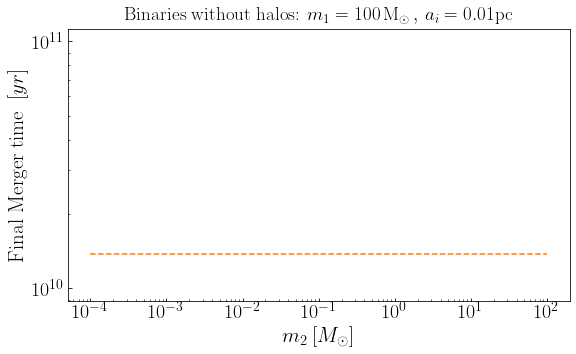

In [2]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'


def final_merger_time_nohalos(m_2):  # assuming a_i = a_f and hence j_i = j_f .
    a_f = a_i
    return (np.sqrt(a_f/a_i)) *t_initial_merger_time



final_merger_time_nohalos_list = np.zeros(len(m_2_list))

for i, m_2 in enumerate(m_2_list):
    final_merger_time_nohalos_list[i] = final_merger_time_nohalos(m_2)
    
    
plt.figure(figsize=(9, 5))

plt.loglog(m_2_list, final_merger_time_nohalos_list, 'C1', linestyle = '--')

np.save('final_merger_time_nohalos_list.npy', final_merger_time_nohalos_list)          
 

plt.xlabel('$m_{2}\:[M_{\odot}]$', fontsize = 21)
plt.ylabel('Final Merger time $\: [yr]$', fontsize = 21)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title(r'Binaries without halos: $m_{1} = 100 \, \mathrm{M_{\odot}} \,,\, a_{i} = 0.01 \mathrm{pc}$', fontsize = 19, pad = 9)
plt.show()     

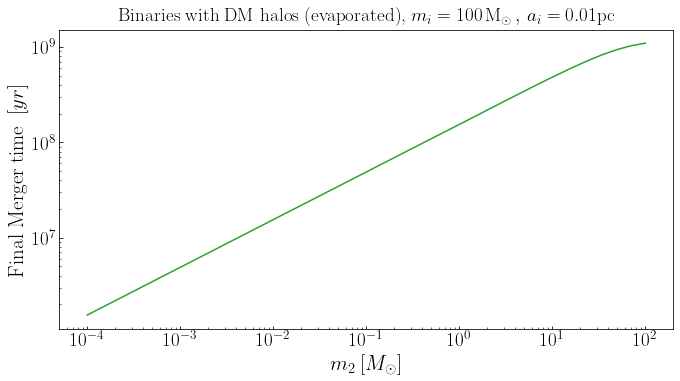

In [3]:
def final_merger_time_evaporatedhalos(m_2, Δ_2):  # j_f = sqrt(a_i/a_f) * j_i
    
    f_pbh = mass_function.f_PBH
    f =  f_pbh*0.85
            
    m_min = 1e-4
    m_max = 100

    def P(m):    #in units of M☉, for PBHs mass range of m_min = 1e-4 M☉ - m_max = 100 M☉ 
        return mass_function.new_PDF(m)

    
    def f_(m):
        return f*P(m)

    def f_b(m_1, m_2):
        return  f_(m_1) + f_(m_2)

    def x̄(m_1,m_2,Δ_1,Δ_2):   
        return (((3 * (m_1 + m_2))/(4 * π * ρ_eq * f_b(m_1, m_2) * np.sqrt(Δ_1 * Δ_2)))**(1/3))

    
    
    def λ(m_1, m_2, Δ_1, Δ_2):  # using x = x_bar
        λ = Symbol('λ')
        roots = solve(λ**2 + (0.0977/0.0068) * λ + ((0.0977/0.0068) * (a_i/x̄(m_1,m_2,Δ_1,Δ_2))), λ)
        return roots[1]
       
    def s(m_1, m_2,Δ_1,Δ_2): # S_dec of the binary decouple.
        return ( (0.03062*λ(m_1, m_2,Δ_1,Δ_2)+ 0.3425) * λ(m_1, m_2,Δ_1,Δ_2) )

    
    def t_dec(m_1, m_2, Δ_1, Δ_2):  #t_dec of the binary decouple.
        return np.sqrt(2) * (np.sqrt(3/(8*π*G*ρ_eq))) * (((2/3)*(s(m_1, m_2, Δ_1, Δ_2)-2)* ((s(m_1, m_2, Δ_1, Δ_2)+1)**(1/2)))+(4/3))

    
    def ρ_bar(m):
        return Ω_cdm * (ρ_eq/2)* (t_eq**(3/2)) * ((2*G*m)**(3/4)) 
    
    def M_1halo(m_1, m_2,Δ_1,Δ_2):
        return (((16*π)/3)*ρ_bar(m_1)*((2*G*m_1*(t_dec(m_1, m_2,Δ_1,Δ_2)**2))**(1/4)))
    
    
    def M_2halo(m_1, m_2,Δ_1,Δ_2):
        return (((16*π)/3)*ρ_bar(m_2)*((2*G*m_2*(t_dec(m_1, m_2,Δ_1,Δ_2)**2))**(1/4)))
    

    def M_binary_initial(m_1, m_2,Δ_1,Δ_2):
        return (m_1 + m_2 + M_1halo(m_1, m_2,Δ_1,Δ_2) + M_2halo(m_1, m_2,Δ_1,Δ_2))
      
    def M_1(m_1, m_2,Δ_1,Δ_2):
        return (m_1 + M_1halo(m_1, m_2,Δ_1,Δ_2))
    
    def M_2(m_1, m_2,Δ_1,Δ_2):
        return (m_2 + M_2halo(m_1, m_2,Δ_1,Δ_2))
    

    #Schwarzchild Radius of the PBH.
    def r_s(m): 
        return ((2*G*m)/(c**2)) 


    #r_turnaround of the dark matter halos, eq.(5) in "WIMPs and stellar-mass primordial black holes are incompatible"
    def r_ta(m): 
        return ((2*G*m*(t_dec(m_1, m_2,Δ_1,Δ_2)**2))**(1/3))


    # The binding energy, E_b of the dark matter halos calculated within r_s and r_ta for dark matter halo's density profile of ρ(r)∝ r^{-9/4}
    def E_b(m): 
        return ((16*π*G*ρ_bar(m)*m*(((r_ta(m))**(-1/4))-((r_s(m))**(-1/4))))-((128/3)*G*(π**2)*(ρ_bar(m)**2)*(((r_ta(m))**(1/2))-((r_s(m))**(1/2)))))
    
    
    def a_final(m_1,m_2,Δ_1,Δ_2):
        return ((G* m_1 * m_2 * a_i)/((G * M_1(m_1, m_2,Δ_1,Δ_2) * M_2(m_1, m_2,Δ_1,Δ_2))-(2 * a_i *(E_b(m_1)+E_b(m_2)))))

    
    return   ((a_final(m_1, m_2,Δ_1,Δ_2)/a_i)**(1/2)) * t_initial_merger_time





final_merger_time_evaporatedhalos_list = np.zeros(len(m_2_list))

for i, (m_2, Δ_2) in enumerate(zip(m_2_list,  Δ_2_list)):
    final_merger_time_evaporatedhalos_list[i] = final_merger_time_evaporatedhalos(m_2,Δ_2)

#np.save('final_merger_time_evaporatedhalos_list.npy', final_merger_time_evaporatedhalos_list)          
    
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.figure(figsize=(11, 5.5))
plt.loglog(m_2_list, final_merger_time_evaporatedhalos_list, 'C2')
plt.xlabel('$m_{2}\:[M_{\odot}]$', fontsize = 21)
plt.ylabel('Final Merger time $\: [yr]$', fontsize = 21)
plt.xticks(fontsize = 19)
plt.yticks(fontsize = 19)
plt.title(r'Binaries with DM halos (evaporated), $m_{i} = 100 \, \mathrm{M_{\odot}} \, , \, a_{i} = 0.01 \mathrm{pc}$', fontsize = 19, pad = 9)
plt.show()     

Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999460187580  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 2.5283s
i = 0
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999402703302  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 2.5526s
i = 1
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999339094942  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 2.5585s
i = 2
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999999268710043  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 2.6378s
i = 3
Evolving from  3

/home/pratibhajangra/Desktop/Modified Work/imripy-main/src/imripy/inspiral.py:361: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return -(1.-e**2)**(3./2.)/2./np.pi *np.sqrt(sp.m_total(a) * a*(1.-e**2)) *  quad(integrand, 0., 2.*np.pi, limit = 100)[0]


A termination event occurred.
 -> Evolution took 260.2084s
i = 34
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999980159581165  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 318.7626s
i = 35
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999977541163952  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 337.8314s
i = 36
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999974403058409  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 367.8440s
i = 37
Evolving from  347222222.2222222  to  1.0 r_isco  with initial eccentricity 0.999970595049403  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
The 

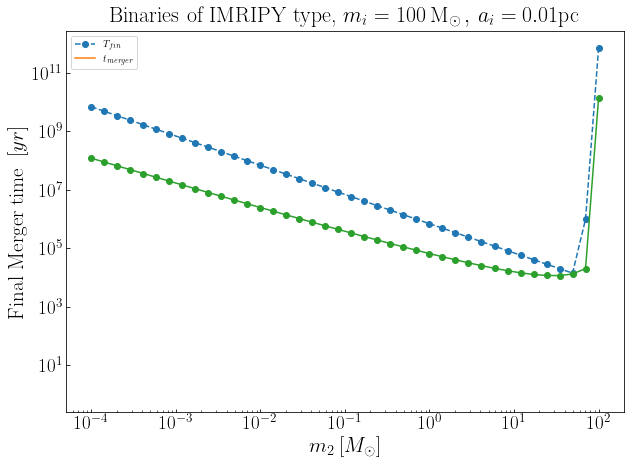

In [6]:
tm_static_halos_list_modified = np.zeros(len(m_2_list))
T_list = np.zeros(len(m_2_list))



for i, (m_2, Δ_2) in enumerate(zip(m_2_list,  Δ_2_list)):
    m_bar = m_1
    M_1 =  m_1 * ms.solar_mass_to_pc  
    M_2 =  m_2 * ms.solar_mass_to_pc 
    
    
    D_luminosity = 0              
    ρ_bar = Ω_cdm * (ρ_eq/2) * (t_eq**(3/2)) * ((2 * G * m_bar)**(3/4))   
    r_spike = 1      # in parsecs, Choosen by choice
    alpha = 9/4
    rho_spike =  ρ_bar * (r_spike**(-alpha)) * ms.solar_mass_to_pc  
    spike = imripy.halo.Spike(rho_spike, r_spike, alpha)
    
    sp = ms.SystemProp(M_1, M_2, spike, D_luminosity)
    a_fin = sp.r_isco()      # Choosen equal to r_icso
    R_fin = sp.r_isco()      # The final condition for the evolution

    f_pbh = mass_function.f_PBH
    f =  f_pbh*0.85
            
    def P(m):    #in units of M☉, for PBHs mass range of m_min = 1e-4 M☉ - m_max = 100 M☉ 
        return mass_function.new_PDF(m)

    m_min = 1e-4
    m_max = 100
    
    def f_(m):
        return f*P(m)

    def f_b(m_1,m_2):
        return  f_(m_1) + f_(m_2)
    
    def x̄(m_1,m_2,Δ_1,Δ_2):   
        return (((3 * (m_1 + m_2))/(4 * π * ρ_eq * f_b(m_1,m_2) * np.sqrt(Δ_1 * Δ_2)))**(1/3))
    

    def λ(m_1, m_2, Δ_1, Δ_2):  # using x = x_bar
        λ = Symbol('λ')
        roots = solve(λ**2 + (0.0977/0.0068) * λ + ((0.0977/0.0068) * (a_i/x̄(m_1,m_2,Δ_1,Δ_2))), λ)
        return roots[1]
        
    def s(m_1, m_2,Δ_1,Δ_2): # S_dec of the binary decouple.
        return  (0.03062*λ(m_1, m_2,Δ_1,Δ_2)+ 0.3425) * λ(m_1, m_2,Δ_1,Δ_2) 

    
    def t_dec(m_1, m_2, Δ_1, Δ_2):  #t_dec of the binary decouple.
        return np.sqrt(2) * (np.sqrt(3/(8*π*G*ρ_eq))) * (((2/3)*(s(m_1, m_2, Δ_1, Δ_2)-2)* ((s(m_1, m_2, Δ_1, Δ_2)+1)**(1/2)))+(4/3))

    
    def ρ_bar(m):
        return Ω_cdm * (ρ_eq/2)* (t_eq**(3/2)) * ((2*G*m)**(3/4)) 
    
            
    def M_halo(m, m_1, m_2, Δ_1, Δ_2):
        return (((16*π)/3)*ρ_bar(m)*((2 * G * m *(t_dec(m_1, m_2, Δ_1, Δ_2)**2))**(1/4)))

            
    def M(m, m_1, m_2, Δ_1, Δ_2):
        return (m + M_halo(m, m_1, m_2, Δ_1, Δ_2))
            
   
    def M_binary_initial(m_1, m_2, Δ_1, Δ_2):
        return (m_1 + m_2 + M_halo(m_1, m_1, m_2, Δ_1, Δ_2) + M_halo(m_2, m_1, m_2, Δ_1, Δ_2))

    def j_initial(m_1, m_2, Δ_1, Δ_2):
        return  (((85/3) * (G**3) * m_1 * m_2 * M_binary_initial(m_1, m_2, Δ_1, Δ_2) * t_m)/((a_i**4)*(c**5)))**(1/7)
    
    
    j_i = j_initial(m_1, m_2,Δ_1, Δ_2 )
    e0  = (1 - (j_i **2))**(1/2)
    
    
    
    m_2_ref = 1 # in units of solar mass
    T = 5e-5 * (t_m * ms.year_to_pc ) * ((m_2/m_2_ref)**(-1))
    T_list[i] =  T/ms.year_to_pc
    
    ev_ecc = imripy.inspiral.Classic.Evolve(sp, a_i, e0,  a_fin = R_fin, t_fin = T)
    tm = ev_ecc.t[-1]
    tm_static_halos_list_modified[i] = tm/ms.year_to_pc
    print("i =", i)
      
    
    while np.isclose(T_list[i], tm_static_halos_list_modified[i]) == True: 
        T_list[i] = T_list[i] * 100 
        ev_ecc = imripy.inspiral.Classic.Evolve(sp, a_i, e0,  a_fin = R_fin, t_fin = T_list[i]*ms.year_to_pc)
        tm_static_halos_list_modified[i] = ev_ecc.t[-1]/ms.year_to_pc
        
            
    
    
    
    
print("T_list =", T_list, "yr")  
print("tm_list =", tm_static_halos_list_modified, "yr")
#np.save('tm_static_halos_list_modified.npy', tm_static_halos_list_modified)          

    
plt.figure(figsize = (10, 7))    
plt.loglog(m_2_list, T_list, '--o', 'C1')     
plt.loglog(m_2_list, tm_static_halos_list_modified, '-o', 'C2')
plt.xticks(fontsize = 19)  
plt.yticks(fontsize = 19) 
plt.legend(["$T_{fin}$","$t_{merger}$"])
    

plt.xlabel('$m_{2}\:[M_{\odot}]$', fontsize = 21)
plt.ylabel('Final Merger time $\: [yr]$', fontsize = 21)
plt.title('Binaries of IMRIPY type, $m_{i} = 100 \, \mathrm{M_{\odot}} \, , \, a_{i} = 0.01 \mathrm{pc}$', fontsize = 22, pad = 9)
plt.savefig('tm_imripy.pdf', bbox_inches='tight')
plt.show()     

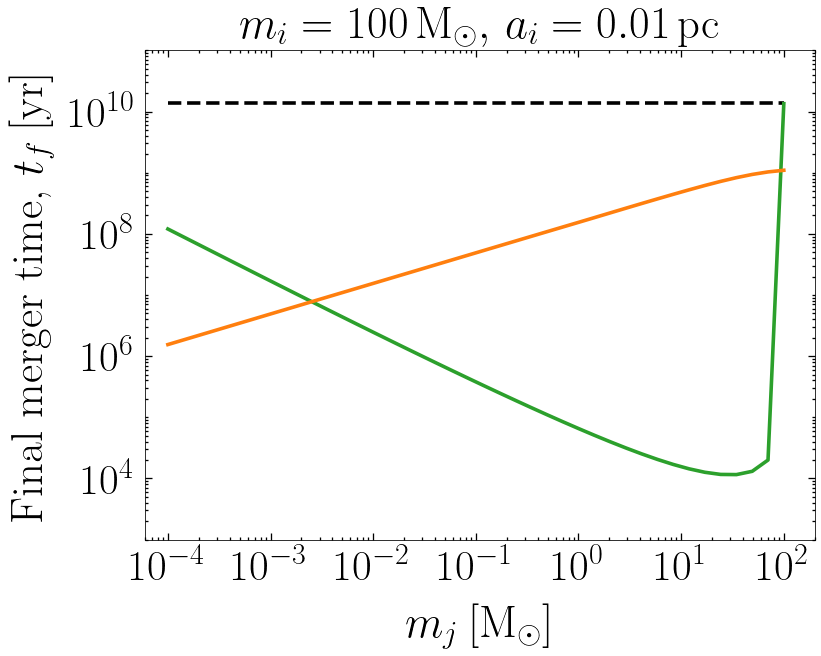

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import imripy
from imripy import merger_system as ms
from scipy.interpolate import interp1d
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit
from numpy import diff
import matplotlib as mpl
import matplotlib.ticker as mticker
import mass_function
from sympy import *
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
}) 





fig, ax = plt.subplots(1, figsize=(12, 9))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.3, length = 3)
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.3, length = 6.7)



ax.loglog(m_2_list, final_merger_time_nohalos_list, 'k--')
ax.loglog(m_2_list, tm_static_halos_list_modified,  'C2' )   #006d77     #ffc300##ffc300 fca311
ax.loglog(m_2_list, final_merger_time_evaporatedhalos_list,  'C1') #d90368
#ax.axvline(x = 2.5e-3)


ax.yaxis.set_major_locator(mticker.LogLocator(numticks= 8))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks= 18, subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9)))
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax.xaxis.set_major_locator(mticker.LogLocator(numticks= 8))
ax.xaxis.set_minor_locator(mticker.LogLocator(numticks= 18, subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9)))
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())


ax.tick_params(axis='x', pad= 9.7)
ax.tick_params(axis='y', pad= 9.7)


plt.rc('lines', linewidth = 3.6)
plt.xticks(fontsize = 43)
plt.yticks(fontsize = 43)

plt.xlim(6e-5, 200)
plt.ylim(1000, 1e11)


#plt.legend(["Without DM spikes", "With static DM spikes", "With evaporated DM spikes"], prop = {'size':48}, 
           #loc = 'center left',  facecolor = 'white', fontsize = 40, labelspacing = 1.2,bbox_to_anchor=(1, 0.5))


#plt.setp(ax.get_legend().get_texts(), fontsize='48')

plt.xlabel('$m_{j}\:[\mathrm{M_{\odot}}]$', fontsize = 45, labelpad = 15)
plt.ylabel('Final merger time, $ t_{f}\: [\mathrm{yr}]$', fontsize = 45, labelpad = 15)
plt.title(r'$m_{i} = 100 \, \mathrm{M_{\odot}}, \,  a_{i} = 0.01 \, \mathrm{pc}$', fontsize = 45, pad = 13)
plt.savefig('finalmergertime2.pdf', bbox_inches = 'tight')
plt.show()